In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
aq_df = pd.read_csv('./data/aiqQuality_201804.csv')
weather_df = pd.read_csv('./data/observedWeather_201804.csv')
gridw_df = pd.read_csv('./data/gridWeather_201804.csv')

## Preprocessing and feature engineering

In [3]:
def fill_small_gap(df,groupKey,attr):
    grouped = df.groupby(groupKey)
    frames = []
    for key,group in grouped:
        group = group.sort_values(by='time')
        X = group[attr].values
        consecutive = 0
        for i in range(1,X.shape[0]):
            if pd.isnull(X[i]):
                consecutive += 1
            else:
                if consecutive < 4:
                    start_idx = i - consecutive - 1
                    if start_idx >= 0 and (not pd.isnull(X[start_idx])):
                        start = X[start_idx]
                        end = X[i]
                        for j in range(1,consecutive+1):
                            X[i-j] = end * (1-j/(consecutive+1) ) + start*j/(consecutive+1)
                            if pd.isnull(X[i-j]):
                                print("set up fail")
                consecutive = 0 #reset the counter
        group[attr] = X
        frames.append(group.copy())
    return pd.concat(frames)

In [4]:
#this should be run for only once / or the long gap will also be filled
print(aq_df.info())
aq_df = fill_small_gap(aq_df,'station_id','PM25_Concentration')
aq_df = fill_small_gap(aq_df,'station_id','PM10_Concentration')
aq_df = fill_small_gap(aq_df,'station_id','NO2_Concentration')
aq_df = fill_small_gap(aq_df,'station_id','CO_Concentration')
aq_df = fill_small_gap(aq_df,'station_id','O3_Concentration')
aq_df = fill_small_gap(aq_df,'station_id','SO2_Concentration')
print(aq_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23310 entries, 0 to 23309
Data columns (total 9 columns):
id                    23310 non-null int64
station_id            23310 non-null object
time                  23310 non-null object
PM25_Concentration    22075 non-null float64
PM10_Concentration    18425 non-null float64
NO2_Concentration     22262 non-null float64
CO_Concentration      22265 non-null float64
O3_Concentration      22118 non-null float64
SO2_Concentration     22284 non-null float64
dtypes: float64(6), int64(1), object(2)
memory usage: 1.6+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23310 entries, 4 to 23283
Data columns (total 9 columns):
id                    23310 non-null int64
station_id            23310 non-null object
time                  23310 non-null object
PM25_Concentration    22277 non-null float64
PM10_Concentration    19345 non-null float64
NO2_Concentration     22414 non-null float64
CO_Concentration      22394 non-null float64
O3_Co

### Clean the abnormal weather data

In [5]:
weather_df = weather_df.loc[weather_df.temperature < 100]

### Examinate the geo info

In [6]:
import geopy.distance

def get_aq_w_dist():
    aq_geo = pd.read_csv('./data/aq_geo.csv')[['station_id','latitude','longitude']].values
    obs_geo = pd.read_csv('observeWeather_geo.csv')[['station_id','latitude','longitude']].values
    grid_geo = pd.read_csv('./data/Beijing_grid_weather_station.csv',names=['station_id','latitude','longitude'])[['station_id','latitude','longitude']].values
    
    aq_start = []
    w_end = []
    dist_list = []
    for i in range(aq_geo.shape[0]):
        for j in range(obs_geo.shape[0]):
            aq_start.append(aq_geo[i][0])
            w_end.append(obs_geo[j][0])
            dist_list.append(geopy.distance.vincenty((aq_geo[i][1],aq_geo[i][2]),(obs_geo[j][1],obs_geo[j][2])).km)

        for k in range(grid_geo.shape[0]):
            aq_start.append(aq_geo[i][0])
            w_end.append(grid_geo[k][0])
            dist_list.append(geopy.distance.vincenty((aq_geo[i][1],aq_geo[i][2]),(grid_geo[k][1],grid_geo[k][2])).km)
    aq_w_dist_df = pd.DataFrame({'aq_start':aq_start,'w_end':w_end,'dist':dist_list})
    aq_w_dist_df = aq_w_dist_df.sort_values(by=['aq_start','dist'])
    
    #get top 3 nearest station for each aq_station
    top3_dict = {}
    aq_w_grouped = aq_w_dist_df.groupby('aq_start')
    for key,group in aq_w_grouped:
        top3_dict[key] = group['w_end'].values[:3]
    aq_group = aq_w_dist_df.groupby('aq_start',as_index=False)
    return aq_group

In [7]:
aq_group = get_aq_w_dist()

### Todo (add the nearest weather info to the aq dataframe)

In [8]:
weather_all = pd.concat([weather_df,gridw_df])

In [9]:
def add_nearest_weather(aq_df,weather_all,aq_w_dist_group,level):
    '''
        This function find the nearesr weather station for the air quality data
    '''
    if level == 0:
        new_df1 = pd.merge(aq_df, aq_group.nth(0),  how='left', left_on=['station_id'], right_on = ['aq_start'])
        aq_all = pd.merge(new_df1, weather_all,  how='left', left_on=['w_end','time'], right_on = ['station_id','time'])
        return aq_all
    else:
        aq_na_df = aq_df[aq_df[['humidity','pressure','temperature','weather','wind_direction','wind_speed']].isnull().any(axis=1)]
        aq_not_na_df = aq_df[aq_df[['humidity','pressure','temperature','weather','wind_direction','wind_speed']].notnull().any(axis=1)]
        aq_na_df = aq_na_df.drop(['aq_start','dist', 'w_end','humidity', 'id_y', 'pressure', 'station_id_y', 'temperature','weather', 'wind_direction', 'wind_speed'],axis=1)
        old_columns = aq_na_df.columns
        new_columns = [x[:-2] if x.endswith('_x') else x for x in old_columns]

        aq_na_df.columns = new_columns 
        
        new_df2 = pd.merge(aq_na_df,  aq_group.nth(level),  how='left', left_on=['station_id'], right_on = ['aq_start'])
        aq_na_df_new = pd.merge(new_df2, weather_all,  how='left', left_on=['w_end','time'], right_on = ['station_id','time'])
        return pd.concat([aq_not_na_df,aq_na_df_new])

In [10]:
#use top 5 nearest weather data usually within 10km
weather_all = pd.concat([weather_df,gridw_df])
aq_all_df = add_nearest_weather(aq_df,weather_all,aq_group,0)
for i in range(1,5):
    print("Level "+str(i)+" #null before",aq_all_df[['humidity','pressure','temperature','weather','wind_direction','wind_speed']].isnull().any(axis=1).sum())
    aq_all_df = add_nearest_weather(aq_all_df,weather_all,aq_group,i)
    print("After: ",aq_all_df[['humidity','pressure','temperature','weather','wind_direction','wind_speed']].isnull().any(axis=1).sum())

Level 1 #null before 347
After:  102
Level 2 #null before 102
After:  66
Level 3 #null before 66
After:  48
Level 4 #null before 48
After:  30


In [11]:
def add_nearby_weather_mean(aq_df,weather_all,aq_w_dist_group,level):
    '''
        Use the mean of weather station that not close enough to fill_na_values if there is not close weather data found
    '''
    aq_na_df = aq_df[aq_df[['humidity','pressure','temperature','weather','wind_direction','wind_speed']].isnull().any(axis=1)]
    aq_not_na_df = aq_df[aq_df[['humidity','pressure','temperature','weather','wind_direction','wind_speed']].notnull().any(axis=1)]
    aq_na_df = aq_na_df.drop(['aq_start','dist', 'w_end','humidity', 'id_y', 'pressure', 'station_id_y', 'temperature','weather', 'wind_direction', 'wind_speed'],axis=1)
    old_columns = aq_na_df.columns
    new_columns = [x[:-2] if x.endswith('_x') else x for x in old_columns]
    aq_na_df.columns = new_columns
    
    _aq_group  = aq_na_df.groupby(['station_id','time'])
    frames = []
    not_found = []
    for key,group in _aq_group:
        _station_id = group.station_id.values[0]
        _time = group.time.values[0]
        _nearbyStationGroup = aq_w_dist_group.head(level)
        _nearbyStations = _nearbyStationGroup.loc[_nearbyStationGroup.aq_start == _station_id]
        dist_mean = _nearbyStations.dist.mean()
        weather_around_df = weather_all.loc[(weather_all.time == _time) & (weather_all.station_id.isin(_nearbyStations.w_end.values))].dropna()
        if weather_around_df.shape[0] > 0:
            weather_around = weather_around_df.mean().to_dict()
            weather_around['aq_start'] = _station_id
            weather_around['dist'] = dist_mean
            weather_around['w_end'] = 'top'+str(level)+'_mean'
            weather_around['time'] = _time
            mean_df = pd.DataFrame(weather_around,index=[0])
        
            group_new = pd.merge(group, mean_df,  how='left', left_on=['station_id','time'], right_on = ['aq_start','time'])
            frames.append(group_new)
        else:
            not_found.append(group)
    result_df = pd.concat([aq_not_na_df]+frames+not_found)
    result_df = result_df.drop(['station_id'],axis=1)
    return result_df
        

In [12]:
#use mean of nearby 26 weather data to fill the gap
print(aq_all_df.columns)
aq_all_df = add_nearby_weather_mean(aq_all_df,weather_all,aq_group,26)
print(aq_all_df.columns)

Index(['id_x', 'station_id_x', 'time', 'PM25_Concentration',
       'PM10_Concentration', 'NO2_Concentration', 'CO_Concentration',
       'O3_Concentration', 'SO2_Concentration', 'aq_start', 'dist', 'w_end',
       'humidity', 'id_y', 'pressure', 'station_id_y', 'temperature',
       'weather', 'wind_direction', 'wind_speed'],
      dtype='object')
Index(['CO_Concentration', 'NO2_Concentration', 'O3_Concentration',
       'PM10_Concentration', 'PM25_Concentration', 'SO2_Concentration',
       'aq_start', 'dist', 'humidity', 'id_x', 'id_y', 'pressure',
       'station_id_x', 'station_id_y', 'temperature', 'time', 'w_end',
       'weather', 'wind_direction', 'wind_speed'],
      dtype='object')


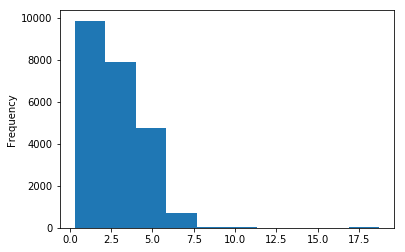

In [13]:
# check the distance used to see whether it is too far away
aq_all_df.dist.plot.hist()